In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from simulation_functions import *
from tqdm import tqdm

In [83]:
g = 30
lam = 5
is_connected = np.random.rand(g,g) < .25
is_connected = np.tril(is_connected, k=-1)
is_connected = is_connected + np.transpose(is_connected)
k = np.multiply(is_connected,np.random.rand(g,g))
K = np.multiply(is_connected,np.random.rand(g,g))
n0 = np.zeros(g) + 0.5
threshold = 1


In [84]:
nt = simulate_dynamics(k,K,lam,n0,thresh = 0.001, cutoff = 500000, dt = 0.01)

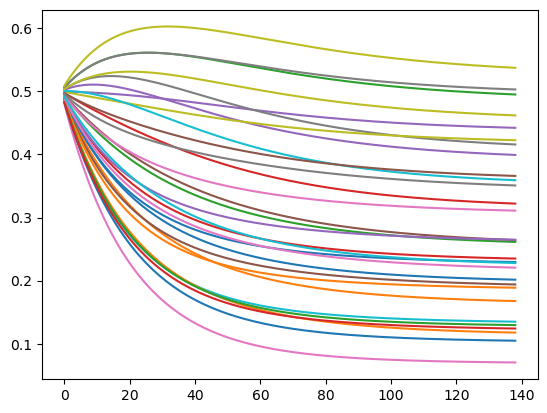

In [85]:
for i in range(nt.shape[0]):
    plt.plot(nt[i,:])

In [145]:
k = load_3d_matrix_from_csv('ks_mode_gaps.csv')[0,:,:]
K = load_3d_matrix_from_csv('KKs_mode_gaps.csv')[0,:,:]
threshold = 2

In [146]:

n0 = np.zeros(g) + 0.5
nt = simulate_dynamics(k,K,lam,n0,thresh = 0.001, cutoff = 500000, dt = 0.01)
n_f = nt[:,-1]
J = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(J)
w = np.real(w)
dlambda = np.sort(w)[-2]/np.sort(w)[-1]
lambdas = [dlambda]
IPR = calc_IPR(w,v)
ks = []
Ks = []
thresholds = iter(np.logspace(2,7,num = 50, base = 2))
for kk in tqdm(range(20000)):
    if dlambda > threshold:
        ks.append(k)
        Ks.append(K)
        threshold = next(thresholds)
    l = np.random.randint(len(np.nonzero(is_connected)[0]))
    i, j = np.nonzero(is_connected)[0][l],np.nonzero(is_connected)[1][l]
    k_new = np.array(k)
    K_new = np.array(K)
    K_new[i,j] = K_new[i,j] + (np.random.rand() - 0.5)*2/5
    k_new[i,j] = k_new[i,j] + (np.random.rand() - 0.5)*2/5
    if k_new[i,j] < 1 and K_new[i,j] < 1 and K_new[i,j] > 0 and k_new[i,j]> 0:
        n0 = np.zeros(g) + 0.5
        nt = simulate_dynamics(k_new,K_new,lam,n0)
        n_f = nt[:,-1]
        J = calc_J(k,K,n_f,lam)
        w, v = np.linalg.eig(J)
        w = np.real(w)
        dlambda_new = np.sort(w)[-2]/np.sort(w)[-1]
        IPR_new = calc_IPR(w,v)
        lambdas.append(dlambda_new)
        if (IPR_new < IPR or IPR_new < 2/g) and (dlambda_new > dlambda):
            k = k_new
            K = K_new
            dlambda = dlambda_new
            IPR = IPR_new


  5%|█▍                            | 923/20000 [00:57<19:45, 16.09it/s]


StopIteration: 

In [144]:
threshold

128

In [131]:
def save_3d_matrix_to_csv(matrix_3d, csv_file_path):
    depth, rows, cols = matrix_3d.shape
    
    with open(csv_file_path, 'w') as csv_file:
        for d in range(depth):
            csv_file.write(f"Depth {d}\n")
            for r in range(rows):
                csv_file.write(','.join(map(str, matrix_3d[d, r])) + '\n')
            csv_file.write('\n')

def load_3d_matrix_from_csv(csv_file_path):
    matrix_slices = []
    current_slice = []
    
    with open(csv_file_path, 'r') as csv_file:
        for line in csv_file:
            if line.strip():  # Non-empty line
                if line.startswith("Depth"):
                    if current_slice:
                        matrix_slices.append(current_slice)
                        current_slice = []
                else:
                    values = line.strip().split(',')
                    current_slice.append(list(map(float, values)))  # Change int to float
    
    if current_slice:
        matrix_slices.append(current_slice)
    
    matrix_3d = np.array(matrix_slices)
    return matrix_3d

In [142]:
np.logspace(2,7,num = 50, base = 2)

array([  4.        ,   4.2931626 ,   4.60781129,   4.94552078,
         5.30798122,   5.69700662,   6.11454394,   6.56268285,
         7.04366615,   7.55990103,   8.1139711 ,   8.70864932,
         9.3469119 ,  10.03195316,  10.76720154,  11.55633675,
        12.4033082 ,  13.31235473,  14.28802588,  15.3352046 ,
        16.45913174,  17.66543222,  18.96014325,  20.3497445 ,
        21.84119052,  23.4419456 ,  25.16002106,  27.00401538,
        28.98315726,  31.10735173,  33.38722979,  35.8342016 ,
        38.46051358,  41.27930966,  44.30469715,  47.55181725,
        51.0369209 ,  54.77745007,  58.79212506,  63.10103819,
        67.72575437,  72.68941901,  78.01687387,  83.73478136,
        89.87175801,  96.45851768, 103.52802526, 111.11566165,
       119.25940085, 128.        ])

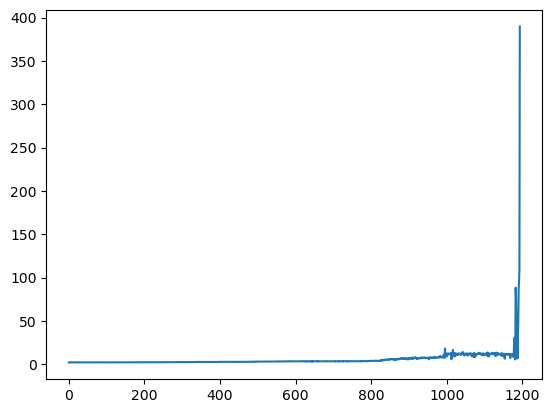

In [89]:
plt.plot(lambdas)

In [147]:
for i in range(0,len(ks)):
    n0 = np.zeros(g) + 0.5
    nt = simulate_dynamics(ks[i],Ks[i],lam,n0)
    n_f = nt[:,-1]
    J = calc_J(ks[i],Ks[i],n_f,lam)
    w, v = np.linalg.eig(J)
    w = np.real(w)
    dlambda_new = np.sort(w)[-2]/np.sort(w)[-1]
    print(dlambda_new)

3.9412184104603707
3.986208655746162
4.200318924625235
4.5021658290269935
4.835931569570316
5.107051944325497
5.881926539751058
6.024716894006594
6.369821318776041
6.6424341636633235
7.3521788844601845
7.79310821353802
8.047533571346824
8.759347275222773
9.376876822420197
9.376876822420197
9.766232657036795
9.766232657036795
9.766232657036795
12.938197567375074
12.938197567375074
12.938197567375074
12.938197567375074
12.938197567375074
12.938197567375074
19.01836938525285
21.76185844068695
21.76185844068695
23.412128567736627
25.747967461298277
25.747967461298277
25.747967461298277
29.076873324078605
29.076873324078605
33.63373412959185
40.33790514871258
40.33790514871258
40.33790514871258
40.33790514871258
48.45905645021664
48.45905645021664
63.2971305276921
63.2971305276921
63.2971305276921
78.58022449158587
78.58022449158587
78.58022449158587
78.58022449158587
97.1583549355404
119.49253918282886
119.49253918282886


In [126]:
i = 5
n0 = np.zeros(g) + 0.5
nt = simulate_dynamics(ks[i],Ks[i],lam,n0)
n_f = nt[:,-1]
J = calc_J(ks[i],Ks[i],n_f,lam)
w, v = np.linalg.eig(J)
w = np.real(w)
w

array([-0.04809362, -8.53566004, -2.1021558 , -8.14619743, -2.70446747,
       -2.70446747, -2.92358458, -3.08887063, -3.5606079 , -3.5606079 ,
       -4.26002049, -4.26002049, -7.35042947, -7.30554389, -7.02963672,
       -4.23997267, -4.23997267, -4.66730979, -4.66730979, -6.67013059,
       -6.20926561, -6.20926561, -6.36300177, -5.46302897, -5.46302897,
       -5.95413069, -5.95413069, -5.11462269, -5.6022328 , -5.6022328 ])

In [151]:
save_3d_matrix_to_csv(np.array(ks), "many_ks.csv")
save_3d_matrix_to_csv(np.array(Ks), "many_KKs.csv")

In [353]:
from scipy.integrate import solve_ivp

In [359]:
def dndt(t,n):
    return calc_dndt(k,K,n,lam)

In [492]:
n_p_0 = n_f +.005*(np.random.random(len(n_f)) - 0.5)

In [507]:
t_span = [0, 200]  # Time span to solve the differential equation
rtol = 1e-6  # Relative tolerance for the solution
atol = 1e-9  # Absolute tolerance for the solution


In [508]:
sol = solve_ivp(dndt, t_span, n_p_0, rtol=rtol, atol=atol, dense_output=True, method='Radau')

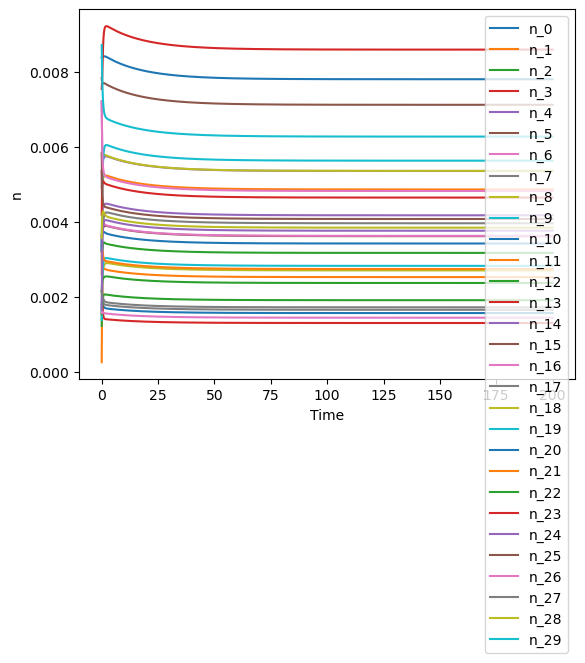

In [509]:
# Create an interpolating function for the solution
sol_fun = sol.sol

# Evaluate the solution at a large number of time points for plotting
t_eval = np.linspace(t_span[0], t_span[1], 1000)
n_eval = sol_fun(t_eval)

# Plot the trajectory of the solution
plt.figure()
for i in range(nt.shape[0]):
    plt.plot(t_eval, n_eval[i], label=f"n_{i}")
plt.xlabel("Time")
plt.ylabel("n")
plt.legend()
plt.show()

In [510]:
n_f = n_eval[:,-1]
J = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(J)


In [511]:
w[0]

(-0.05547271758273871+0j)

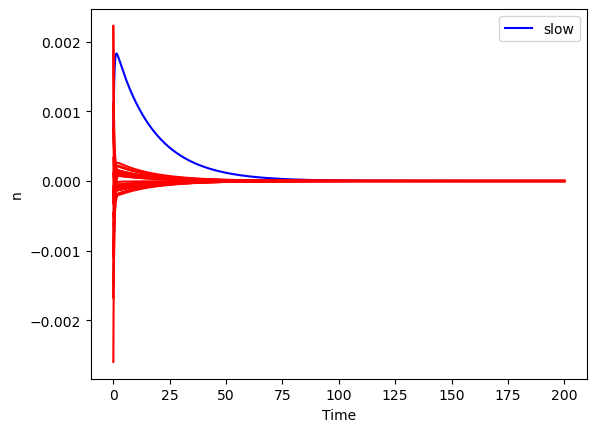

In [512]:
# Plot the trajectory of the solution
plt.figure()
for i in range(nt.shape[0]):
    v_plot = np.dot(n_eval.T,v[:,i])
    v_plot = (v_plot - v_plot[-1])
    if i == 0:
        plt.plot(t_eval, v_plot, label="slow",color = 'b')
    else:
        plt.plot(t_eval, v_plot,color = 'r')
plt.xlabel("Time")
plt.ylabel("n")
#plt.ylim([-0.001,0.001])
#plt.yscale('log')
plt.legend()
plt.show()

In [519]:
np.savetxt("KK.csv", K, delimiter=",")
np.savetxt("k.csv", k, delimiter=",")
